In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.0
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using dask       : 2020.12.0


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 10
#maxevents = 20000
maxevents = -1

workers = 1
#workers = 8

# Input files
features_fname = 'features_zone%i.h5' % zone


# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. workers          : {0}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 1


### Load data

In [5]:
import h5py

def load_features():
  file_handles = []
  features = []
  truths = []
  for i in range(num_emtf_zones):
    fname = features_fname.replace('zone%i' % zone, 'zone%i' % i)  # modify filename
    loaded_h5 = h5py.File(fname, 'r')
    file_handles.append(loaded_h5)
    features.append(da.from_array(loaded_h5['features']))
    truths.append(da.from_array(loaded_h5['truths']))
  features = da.concatenate(features, axis=0)
  truths = da.concatenate(truths, axis=0)
  features, truths = dask.compute(features, truths)
  logger.info('features: {0} (dtype={1}) truths: {2} (dtype={3})'.format(features.shape, features.dtype, truths.shape, truths.dtype))

  # Close file handles
  for i in range(num_emtf_zones):
    file_handles[i].close()
  return features, truths

In [6]:
# Load features and truths
features, truths = load_features()

[INFO    ] features: (1751565, 40) (dtype=int32) truths: (1751565, 9) (dtype=float32)


In [7]:
def train_test_split(*arrays, test_size=0.4):
  assert(len(arrays) >= 2)
  num_samples = arrays[0].shape[0]
  num_train_samples = int(num_samples * (1.0 - test_size))
  num_test_samples = num_samples - num_train_samples
  index_array = np.arange(num_samples)
  np.random.shuffle(index_array)
  index_array_train, index_array_test = index_array[:num_train_samples], index_array[num_train_samples:]

  import itertools
  train_test_pairs = (
      (arr[index_array_train], arr[index_array_test])
      for arr in arrays
  )
  return tuple(itertools.chain.from_iterable(train_test_pairs))

In [8]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, truths)

# Convert x_train, x_test to floating-point
ismasked = lambda x: x == ma_fill_value
x_train_mask = ismasked(x_train)
x_test_mask = ismasked(x_test)
x_train = x_train.astype(np.float32) 
x_test = x_test.astype(np.float32)
x_train[x_train_mask] = np.nan
x_test[x_test_mask] = np.nan

# Modify parameter of interest
pt_regr_scale = 1.
y_train = y_train[:, 0:1]
y_test = y_test[:, 0:1]
y_train *= pt_regr_scale
y_test *= pt_regr_scale

logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (1050939, 40) y_train: (1050939, 1) x_test: (700626, 40) y_test: (700626, 1)


In [9]:
# Preprocessing layer
from k_preprocessing_normalization import Normalization as MyNormalization
preprocessing_layer = MyNormalization()
preprocessing_layer.adapt(x_train)

y_preprocessing_layer = MyNormalization()
y_preprocessing_layer.adapt(y_train)

In [10]:
# Debug
_ = np.nanmean(x_train, axis=0, dtype=np.float64)
assert _.shape == preprocessing_layer.mean.shape
assert np.allclose(_, preprocessing_layer.mean.numpy())
_ = np.nanvar(x_train, axis=0, dtype=np.float64)
assert _.shape == preprocessing_layer.variance.shape
assert np.allclose(_, preprocessing_layer.variance.numpy())

In [11]:
#FIXME
x_train = nan_to_num(x_train)
x_test = nan_to_num(x_test)

### Create model

In [12]:
def create_model():
  inputs = keras.Input(shape=(40,), name='inputs')
  x = preprocessing_layer(inputs)
  x = k_layers.Dense(30, activation='relu', name='dense_0')(x)
  x = k_layers.Dense(20, activation='relu', name='dense_1')(x)
  x = k_layers.Dense(10, activation='relu', name='dense_2')(x)
  outputs = k_layers.Dense(1, activation='linear', name='outputs')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='mse')
  model.summary()
  return model

model = create_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 40)]              0         
_________________________________________________________________
normalization (Normalization (None, 40)                120       
_________________________________________________________________
dense_0 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
outputs (Dense)              (None, 1)                 11        
Total params: 2,191
Trainable params: 2,071
Non-trainable params: 120
_________________________________________________________

### Train model

In [13]:
epochs = 100
batch_size = 2048
callbacks = None

history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

Epoch 1/100
462/462 [==============================] - 16s 17ms/step - loss: 0.0466 - val_loss: 0.0094
Epoch 2/100
462/462 [==============================] - 6s 14ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 3/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 4/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 5/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 8/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 10/100
462/462 [==============================] - 3s 7ms/step - loss: 0.0045 - val

462/462 [==============================] - 2s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 82/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 83/100
462/462 [==============================] - 3s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 84/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 85/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 86/100
462/462 [==============================] - 3s 6ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 87/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 88/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 89/100
462/462 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 90/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


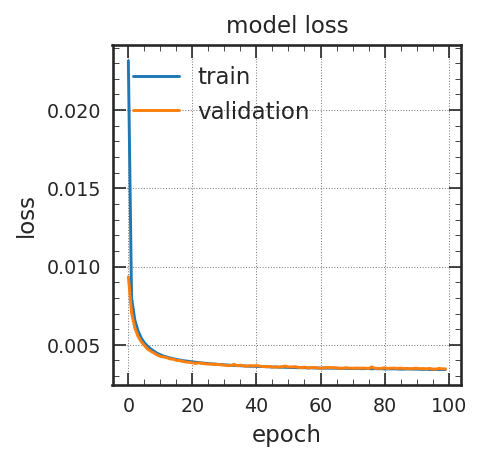

[INFO    ] Epoch 100/100 - loss: 0.0034 - val_loss: 0.0035


In [14]:
# Plot loss vs epoch
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
#ax.set_ylim(2,8)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1:.4f} - val_loss: {2:.4f}'.format(*metrics))

### Evaluate model

In [15]:
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

y_test_true /= pt_regr_scale
y_test_pred /= pt_regr_scale

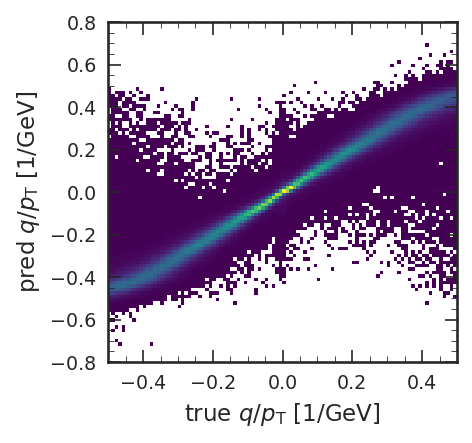

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(3,3))
xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
plt.show()

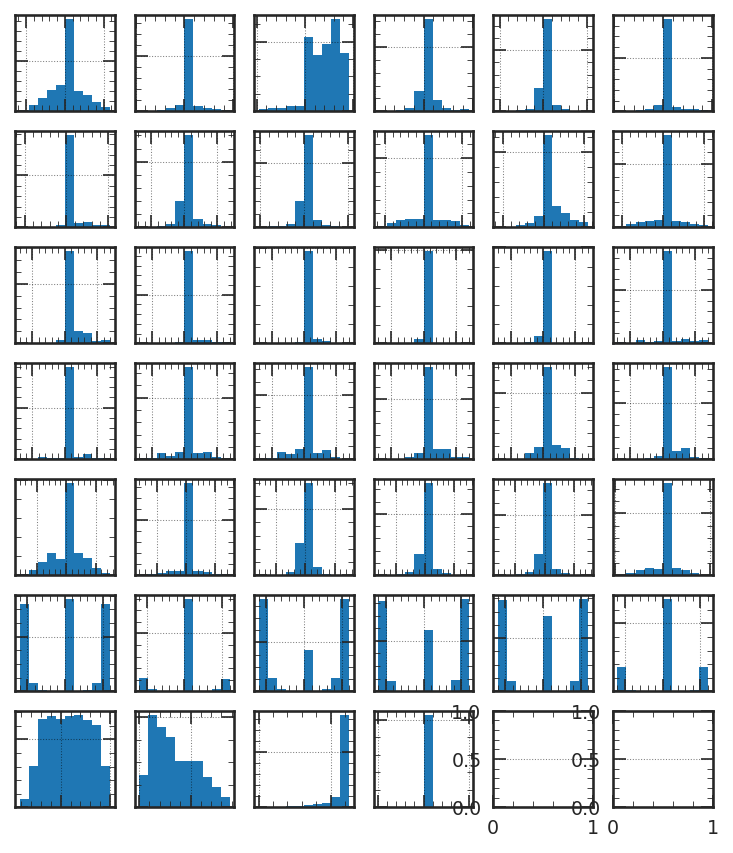

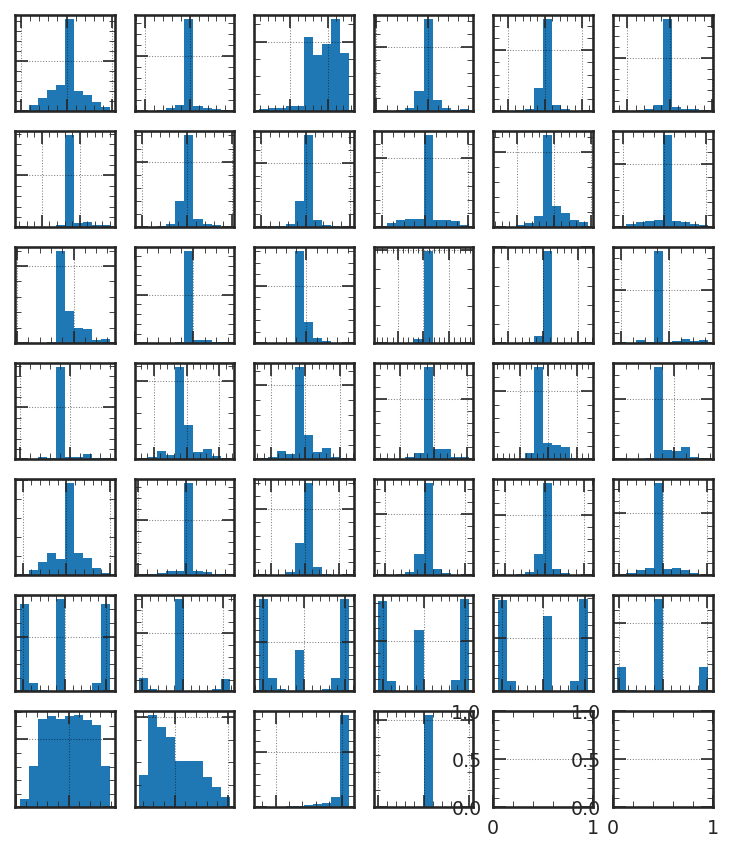

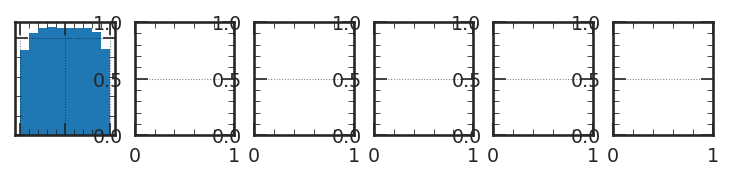

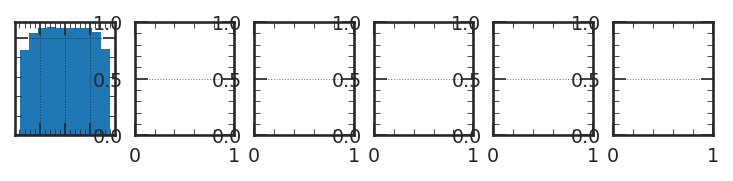

In [17]:
# Check x_train, x_train_normed, y_train, y_train_normed

x_train_normed = preprocessing_layer(x_train).numpy()
y_train_normed = y_preprocessing_layer(y_train).numpy()

def doit():
  fig, axs = plt.subplots(ni, nj, figsize=(6,6*ni/nj))
  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= nij:
        break
      #
      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(axdata[:, ij])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  #
  plt.show()

ni, nj = 7, 6
nij = 40
axdata = x_train
doit()

axdata = x_train_normed
doit()

ni, nj = 1, 6
nij = 1
axdata = y_train
doit()

axdata = y_train_normed
doit()